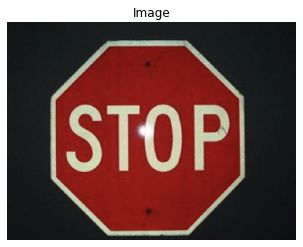

In [480]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np

dataDir = '../dataset/images' 

img = cv2.imread(os.path.join(dataDir, 'road58.png'))

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title('Image')
plt.axis('off')
plt.show()

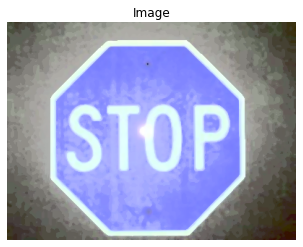

In [481]:
# Image Pre-processing

# Improve Lighting

imgYUV = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

imgYUV[:, :, 0] = cv2.equalizeHist(imgYUV[:, :, 0])

imgBetterLighting = cv2.cvtColor(imgYUV, cv2.COLOR_YUV2BGR)

imgHSV = cv2.cvtColor(imgBetterLighting, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(imgHSV)

lim = 255 - 50
v[v > lim] = 255
v[v <= lim] += 50

final_hsv = cv2.merge((h, s, v))
imgBetterLighting = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

# Smooth

imgWithMedianFilter = cv2.medianBlur(imgBetterLighting, 5)

plt.imshow(imgWithMedianFilter)
plt.title('Image')
plt.axis('off')
plt.show()


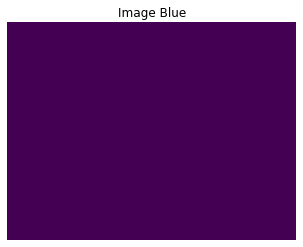

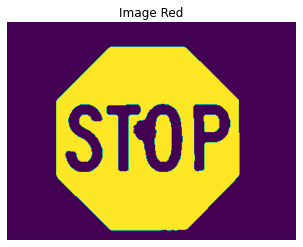

In [482]:
# Image Segmentation

#set the bounds for the red hue
lower_red_n1 = np.array([0,70,60])
upper_red_n1 = np.array([10,255,255])

lower_red_n2 = np.array([170,70,60])
upper_red_n2 = np.array([180,255,255])

lower_blue_n3 = np.array([78,158,124])
upper_blue_n3 = np.array([138,255,255])

#create a mask using the bounds set

img_hsv = cv2.cvtColor(imgWithMedianFilter, cv2.COLOR_BGR2HSV)


mask_1 = cv2.inRange(img_hsv, lower_red_n1, upper_red_n1)
mask_2 = cv2.inRange(img_hsv, lower_red_n2, upper_red_n2)

mask_red = mask_1 + mask_2

mask_blue = cv2.inRange(img_hsv, lower_blue_n3, upper_blue_n3)

plt.imshow(mask_blue)
plt.title('Image Blue')
plt.axis('off')
plt.show()
plt.imshow(mask_red)
plt.title('Image Red')
plt.axis('off')
plt.show()

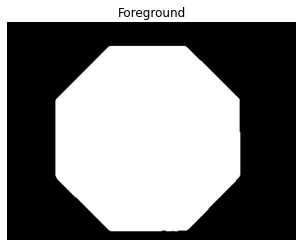

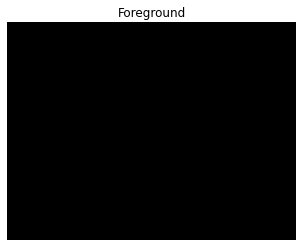

In [483]:
# Image Thresholding and Morphological Operations

# Red

# Removing Noise
kernel = np.ones((3, 3),np.uint8)
processed_red = cv2.morphologyEx(mask_red, cv2.MORPH_OPEN, kernel, iterations = 1)
processed_red = cv2.morphologyEx(processed_red, cv2.MORPH_DILATE, kernel, iterations = 1)

# Floodfill

red_floodfill = processed_red.copy()

h, w = processed_red.shape[:2]

mask = np.zeros((h+2, w+2), np.uint8)

cv2.floodFill(red_floodfill, mask, (0,0), 255)

red_floodfill_inv = cv2.bitwise_not(red_floodfill)

filled_red = processed_red | red_floodfill_inv

# Blue

# Removing Noise
kernel = np.ones((3, 3),np.uint8)
processed_blue = cv2.morphologyEx(mask_blue, cv2.MORPH_OPEN, kernel, iterations = 1)
processed_blue = cv2.morphologyEx(processed_blue, cv2.MORPH_DILATE, kernel, iterations = 1)


# Floodfill

blue_floodfill = processed_blue.copy()

h, w = processed_blue.shape[:2]

mask = np.zeros((h+2, w+2), np.uint8)

cv2.floodFill(blue_floodfill, mask, (0,0), 255)

blue_floodfill_inv = cv2.bitwise_not(blue_floodfill)

filled_blue = processed_blue | blue_floodfill_inv



plt.imshow(filled_red, cmap='gray')
plt.title('Foreground')
plt.axis('off')
plt.show()
plt.imshow(filled_blue, cmap='gray')
plt.title('Foreground')
plt.axis('off')
plt.show()

Found STOP sign


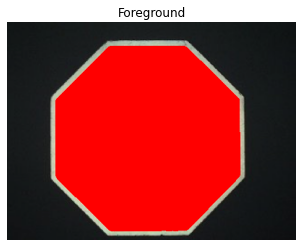

In [484]:
# Shape Recognition

# Red
debug = "red"

# Octagon Detection
contours_red, hierarchy_red = cv2.findContours(filled_red, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours_red:
    approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), True)
    #print(len(approx))

    if len(approx) == 8:
        print('Found STOP sign')
        img_red_contours = cv2.drawContours(img, [cnt], 0, (0,0,255), -1)

    elif len(approx) >= 12:
        print('Found red circle sign')
        img_red_contours = cv2.drawContours(img, [cnt], 0, (0,0,255), -1)

# Blue

contours_blue, hierarchy_blue = cv2.findContours(processed_blue, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours_blue:
    approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), True)
    #print(len(approx))

    if len(approx) == 4:
        print('Found BLUE sign')
        debug = "blue"
        img_blue_contours = cv2.drawContours(img, [cnt], 0, (255,0,0), -1)


if debug=="red":
    plt.imshow(cv2.cvtColor(img_red_contours, cv2.COLOR_BGR2RGB))
    plt.title('Foreground')
    plt.axis('off')
    plt.show()
elif debug == "blue":
    plt.imshow(cv2.cvtColor(img_blue_contours, cv2.COLOR_BGR2RGB))
    plt.title('Foreground')
    plt.axis('off')
    plt.show()